# Super Resolution Diffusion Model Training Code
## Group 6 Super Resolution Project

Written following the guide at:

https://huggingface.co/docs/diffusers/en/tutorials/basic_training

and with reference to

https://arxiv.org/pdf/2104.07636

https://arxiv.org/pdf/2006.11239

## Training Code

Make sure to install our package beforehand.

In [1]:

import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.functional import interpolate
import py7zr as py7zr

import diffusers
import accelerate

from super_resolution.src.sen2venus_dataset import S2VSite, S2VSites, create_train_test_split
from super_resolution.src.visualization import plot_gallery


/Users/nazeefhamid/Documents/Courses/STAT3007/Project/DLProjectEnv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Defining Training Configuration

All the training parameters are set here for convenience.

In [49]:
# Training Configuration
from dataclasses import dataclass
@dataclass
class TrainingConfig:
    image_size = 256  # the generated image resolution
    train_batch_size = 1 # how many images to sample during training
    num_epochs = 1
    train_sites = set(["SO2"])
    data_dir = "../Data"
    output_dir = '../Results'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 1
    mixed_precision = 'fp16' if device == 'cuda' else 'no'# `no` for float32, `fp16` for automatic mixed precision
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()


### Loading Data

In [50]:
train_data, test_data = create_train_test_split(
    data_dir = config.data_dir,
    seed = -1,
    sites = config.train_sites,
    device = config.device,
)

train_dataloader = DataLoader(train_data, batch_size=config.train_batch_size)
test_dataloader = DataLoader(test_data, batch_size=1)

### Defining Transforms

In [51]:
import torchvision.transforms.v2 as transforms

def normalize_tensor(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    return normalized_tensor
    
# preprocessing
process = nn.Sequential(
    transforms.Lambda(normalize_tensor)
)

# upscale = lambda x: interpolate(x, size=(256, 256), mode="bicubic")

class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))

upscale = Upsample(3)



### Defining the U-Net to be used

In [52]:
from diffusers import UNet2DModel

# Prior to Test 7
# Test 8
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=6,  # 6 channels since the input is a concat of noise + upscaled low res
    out_channels=3,  # 3 RGB out channels
    layers_per_block=3,  # how many ResNet layers to use per UNet block
     # the number of output channels for each UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
)

### Noise Pipelines and Optimizer

In [53]:
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(model.parameters(), lr = config.learning_rate)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs))


### Training Loop

In [54]:
import torch.nn.functional as F
from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, upscaler, process):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare the model and optimizer
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    upscale.to(accelerator.device)
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            low, high = batch
            low, high = process(low), process(high) # pre processing (normalise)
            upscaled = upscaler(low)

            # Sample noise to add to the images
            noise = torch.randn(high.shape, device=high.device)
            bs = high.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=high.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(high, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noisy_images = torch.concat([noisy_images, upscaled], dim=1)
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            pipeline.save_pretrained(config.output_dir)


### Launch Training

In [55]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, upscale, process)

notebook_launcher(train_loop, args, num_processes=1)


Launching training on MPS.


Epoch 0:   0%|                                                                                                                                                                            | 0/258 [01:16<?, ?it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 18.13 GB, other allocations: 2.61 MB, max allowed: 18.13 GB). Tried to allocate 2.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

## Testing Code

###  Load Model

Will need to be configured to the location of the model files

In [ ]:
model_location = config.output_dir
loadModel = DDPMPipeline.from_pretrained(model_location)
loadModel.to(config.device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "/content/drive/MyDrive/STAT3007",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

### Testing Code Loop
Generates a High resolution sample from a low resolution input

In [ ]:
@torch.no_grad
def test_diffuse(pipeline, upscaler, low, generator = None, process = None):

    noise = torch.randn(
            (1, 3, pipeline.unet.sample_size, pipeline.unet.sample_size),
            generator=generator,
        )
    noise = noise.to(pipeline.device)

    upscaled = upscaler(low)
    upscaled = upscaled.to(pipeline.device)
    # set step values
    pipeline.scheduler.set_timesteps(1000)

    for t in pipeline.progress_bar(pipeline.scheduler.timesteps):
            # 1. predict noise model_output
            image = torch.concat([noise, upscaled], dim=1)
            model_output = pipeline.unet(image, t).sample

            # 2. compute previous image: x_t -> t_t-1
            noise = pipeline.scheduler.step(model_output, t, noise, generator=generator).prev_sample


    if process:
        # noise = process(noise)
        noise = process(noise / 2 + 0.5)
    else:
        noise = (noise / 2 + 0.5).clamp(0, 1)
    noise = noise.cpu().squeeze(0).permute(2,1,0)
    return noise

### Generating Test Images

In [ ]:
test_imgs = []
titles = []
for (i, img) in enumerate(test_dataloader):
  if i <= 100:
    if i % 10 == 0:
      titles.append(f"Low Res {i}")
      titles.append(f"Naive Upscale {i}")
      titles.append(f"Upscaled {i}")
      titles.append(f"High Res {i}")
      low, high = img
      # low, high = process(low), process(high)
      upscaled = test_diffuse(loadModel, upscale, low, process = process)
      test_imgs.append(low.squeeze(0).permute(2,1,0))
      test_imgs.append(upscale(low).squeeze(0).permute(2,1,0))
      test_imgs.append(upscaled)
      test_imgs.append(high.squeeze(0).permute(2,1,0))
test_imgs = [t.cpu() for t in test_imgs]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

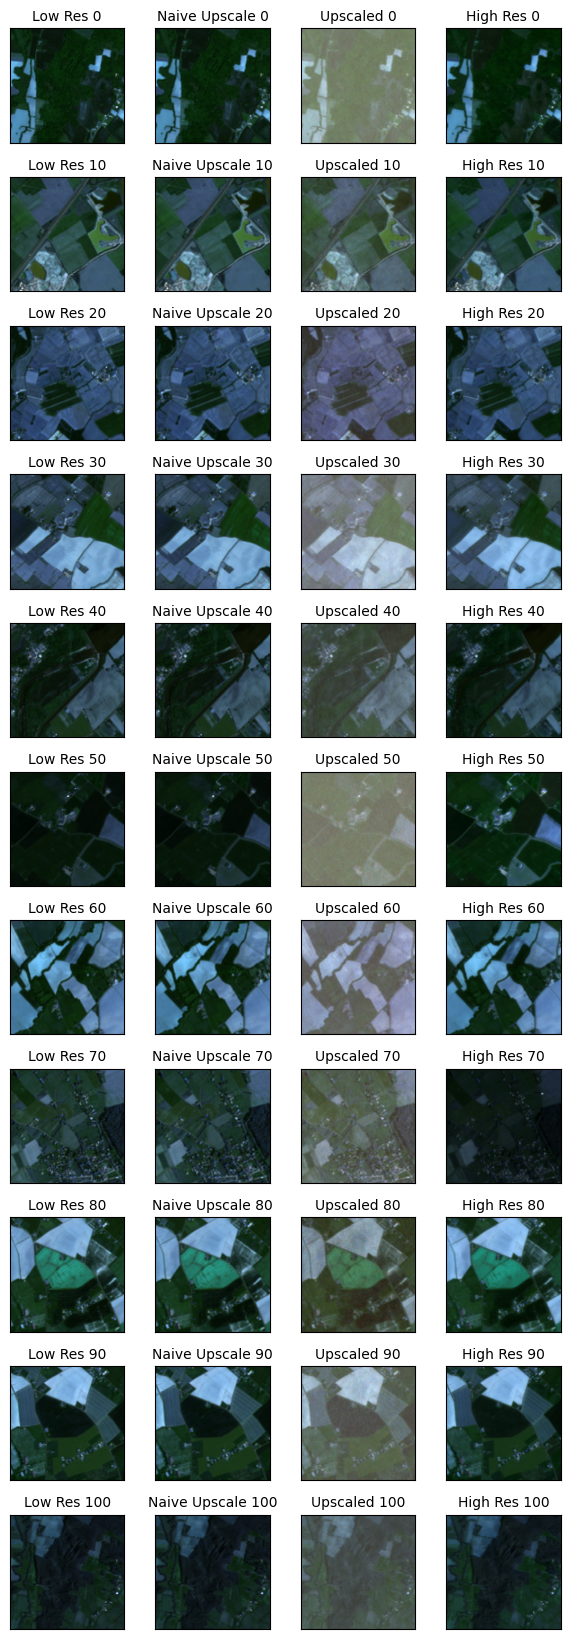

In [ ]:
plot_gallery(test_imgs, titles, nrow = 11)